# 数据挖掘部分，TA可一键运行↓

In [2]:
# HW3: MY DATA MY MODEL
# 姓名：张嘉麟-GROUP 2
# 负责区域: 北京-海淀-西二旗
############################################

##导入需要的包
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.common import NoSuchElementException
from time import sleep
import pandas as pd
import re
from tqdm import tqdm

# ================================
# 配置 Selenium，使用edge浏览器，
# ================================
driver = webdriver.Edge()

# ================================
# 定义提取数字的函数
# ================================

def extract_number(text):
    """从文本中提取数字"""
    if not text:
        return None
    match = re.search(r'(\d+(?:\.\d+)?)', text)
    return float(match.group(1)) if match else None

# ================================
# Part 1: 爬取租房数据
# ================================
print("=" * 60)
print("开始爬取租房数据")
print("=" * 60)

url_rent = 'https://zu.fang.com/house-a015277-b07195/'  ##海淀-西二旗租房的网址
driver.get(url_rent)
sleep(3)

rent_list = []
Num_Pages = 20  ##设定最大查找页数
errors = []  # 收集错误信息

# 使用tqdm创建进度条
pbar = tqdm(total=Num_Pages, desc="租房数据爬取", unit="页")

i = 0
while i < Num_Pages:
    try:
        # 先定位到房源列表的主容器 dl.list
        house_elements = driver.find_elements(By.CSS_SELECTOR, 'dl.list')
        
        if not house_elements:
            errors.append(f"第 {i+1} 页: 未找到房源数据")
            break
        
        page_count = 0  # 当前页成功提取的数据数
        for house in house_elements:
            try:
                # 1.定位到价格区域 div.moreInfo
                price_div = house.find_element(By.CSS_SELECTOR, 'div.moreInfo')
                
                # 2.定位到 span.price，提取租金
                price_span = price_div.find_element(By.CSS_SELECTOR, 'span.price')
                rent_text = price_span.text.strip()
                
                # 3.使用正则函数提取租金数字
                rent = extract_number(rent_text)
                
                # 第四步：定位到房源信息 p.font15
                info_p = house.find_element(By.CSS_SELECTOR, 'p.font15')
                info_text = info_p.text
                
                # 第五步：使用正则提取面积（如18㎡）
                area_match = re.search(r'(\d+(?:\.\d+)?)[㎡平米]', info_text)
                area = float(area_match.group(1)) if area_match else None
                
                # 只保存有效数据，并添加location
                if rent and area:
                    rent_list.append({
                        'rent': rent,
                        'area': area,
                        'location': '北京-海淀-西二旗'
                    })
                    page_count += 1
                    
            except Exception:
                continue  # 单个房源错误不记录，继续处理下一个
        
        # 更新进度条描述信息
        pbar.set_postfix({'当前页数据': page_count, '总数据': len(rent_list)})
        pbar.update(1)
        
        # 点击下一页 - 根据实际HTML结构定位
        try:
            # 定位翻页区域 div.fanye
            fanye_div = driver.find_element(By.CSS_SELECTOR, 'div.fanye')
            
            # 查找"下一页"链接
            next_button = fanye_div.find_element(By.LINK_TEXT, '下一页')
            next_button.click()
            sleep(2)
            i += 1
        except NoSuchElementException:
            pbar.close()
            print("\n已到达最后一页")
            break
            
    except Exception as e:
        errors.append(f"第 {i+1} 页: {str(e)}")
        pbar.close()
        break

pbar.close()

# 输出汇总信息
print(f"\n租房数据爬取完成！")
print(f"  - 成功爬取: {len(rent_list)} 条数据")
print(f"  - 实际爬取页数: {i+1}/{Num_Pages} 页")

# 如果有错误，集中显示
if errors:
    print(f"\n发生 {len(errors)} 个错误:")
    for error in errors:
        print(f"  - {error}")

# ================================
# Part 2: 爬取二手房数据
# ================================
print("\n" + "=" * 60)
print("开始爬取二手房数据")
print("=" * 60)

url_esf = 'https://esf.fang.com/house-a015277-b07195/' #海淀-西二旗二手房的网址
driver.get(url_esf)
sleep(3)

esf_list = []
errors = []  # 重置错误列表

# 使用tqdm创建进度条
pbar = tqdm(total=Num_Pages, desc="二手房数据爬取", unit="页")

i = 0
while i < Num_Pages:
    try:
        # 先定位到房源列表的主容器 dl.clearfix
        house_elements = driver.find_elements(By.CSS_SELECTOR, 'dl.clearfix[dataflag="bg"]')
        
        if not house_elements:
            errors.append(f"第 {i+1} 页: 未找到房源数据")
            break
        
        page_count = 0  # 当前页成功提取的数据数
        for house in house_elements:
            try:
                # 1.定位到价格区域 dd.price_right
                price_dd = house.find_element(By.CSS_SELECTOR, 'dd.price_right')
                
                # 2.定位到 span.red 下的b标签，提取价格数字
                price_b = price_dd.find_element(By.CSS_SELECTOR, 'span.red b')
                price_text = price_b.text.strip()
                
                # 3.使用正则提取价格数字
                price = extract_number(price_text)
                
                # 4.定位到房源信息 p.tel_shop
                info_p = house.find_element(By.CSS_SELECTOR, 'p.tel_shop')
                info_text = info_p.text
                
                # 5.使用正则提取面积（格式：144.84㎡）
                area_match = re.search(r'(\d+(?:\.\d+)?)[㎡平米]', info_text)
                area = float(area_match.group(1)) if area_match else None
                
                # 只保存有效数据并添加location
                if price and area:
                    esf_list.append({
                        'total_price': price,
                        'area': area,
                        'location': '北京-海淀-西二旗'
                    })
                    page_count += 1
                    
            except Exception:
                continue  # 单个房源错误不记录，继续处理下一个
        
        # 更新进度条描述信息
        pbar.set_postfix({'当前页数据': page_count, '总数据': len(esf_list)})
        pbar.update(1)
        
        # 点击下一页
        try:
            # 通过文本定位下一页
            next_button = driver.find_element(By.LINK_TEXT, '下一页')
            next_button.click()
            sleep(2)
            i += 1
        except NoSuchElementException:
            pbar.close()
            print("\n已到达最后一页")
            break
            
    except Exception as e:
        errors.append(f"第 {i+1} 页: {str(e)}")
        pbar.close()
        break

pbar.close()

# 输出汇总信息
print(f"\n二手房数据爬取完成")
print(f"  - 成功爬取: {len(esf_list)} 条数据")
print(f"  - 实际爬取页数: {i+1}/{Num_Pages} 页")

# 如果有错误，集中显示
if errors:
    print(f"\n发生 {len(errors)} 个错误:")
    for error in errors:
        print(f"  - {error}")

# ================================
# Part 3: 关闭浏览器
# ================================
driver.quit()
print("浏览器已关闭")

# ================================
# Part 4: 数据转换为 DataFrame
# ================================
df_rent = pd.DataFrame(rent_list)
df_esf = pd.DataFrame(esf_list)

# ================================
# Part 5: 数据预览与统计
# ================================
print("\n" + "=" * 60)
print("数据预览与统计")
print("=" * 60)

print("\n【租房数据】前10条:")
print(df_rent.head(10))
print(f"\n【租房数据】描述性统计:")
print(df_rent.describe())

print("\n" + "=" * 60)

print("\n【二手房数据】前10条:")
print(df_esf.head(10))
print(f"\n【二手房数据】描述性统计:")
print(df_esf.describe())

# ================================
# Part 6: 保存数据
# ================================
# 保存为 parquet 格式
df_rent.to_parquet('xierqi_rent.parquet')
df_esf.to_parquet('xierqi_esf.parquet')

print("\n数据已成功保存:")
print(f"  - xierqi_rent.parquet: {len(df_rent)} 条记录")
print(f"  - xierqi_esf.parquet: {len(df_esf)} 条记录")

开始爬取租房数据


租房数据爬取:  35%|██████████████▋                           | 7/20 [00:40<01:14,  5.75s/页, 当前页数据=60, 总数据=420]?, ?页/s]



已到达最后一页

租房数据爬取完成！
  - 成功爬取: 420 条数据
  - 实际爬取页数: 7/20 页

开始爬取二手房数据


二手房数据爬取:  60%|███████████████████████▍               | 12/20 [01:10<00:47,  5.90s/页, 当前页数据=45, 总数据=705]?, ?页/s]



已到达最后一页

二手房数据爬取完成
  - 成功爬取: 705 条数据
  - 实际爬取页数: 12/20 页
浏览器已关闭

数据预览与统计

【租房数据】前10条:
      rent   area   location
0   2300.0   18.0  北京-海淀-西二旗
1   2100.0   16.0  北京-海淀-西二旗
2  48000.0  268.0  北京-海淀-西二旗
3   5600.0   70.0  北京-海淀-西二旗
4  12000.0  143.0  北京-海淀-西二旗
5   9500.0  107.0  北京-海淀-西二旗
6  42000.0  294.0  北京-海淀-西二旗
7  13000.0  152.0  北京-海淀-西二旗
8  15900.0  187.0  北京-海淀-西二旗
9  12000.0  138.0  北京-海淀-西二旗

【租房数据】描述性统计:
               rent        area
count    420.000000  420.000000
mean   10358.107143  100.326190
std     9406.246056   67.221365
min     1500.000000    8.000000
25%     6000.000000   60.000000
50%     7145.000000   83.000000
75%    11300.000000  137.000000
max    48000.000000  371.000000


【二手房数据】前10条:
   total_price    area   location
0       1539.0  225.44  北京-海淀-西二旗
1        410.0   88.49  北京-海淀-西二旗
2       1999.0  255.95  北京-海淀-西二旗
3       1520.0  153.00  北京-海淀-西二旗
4       1360.0  158.54  北京-海淀-西二旗
5       1099.0  120.61  北京-海淀-西二旗
6       2280.0  297.09  北京-海淀-西二旗
7    

# 数据合并和建模部分，需要读取数据（TA无法一键运行），这里只展示代码和结果

### 数据合并

In [3]:
import pandas as pd
import numpy as np

# 定义文件路径
esf_files = [
    'HW3_My_Data_My_Model/qinghe_esf.parquet',
    'HW3_My_Data_My_Model/shangdi_esf.parquet',
    'HW3_My_Data_My_Model/xierqi_esf.parquet',
    'HW3_My_Data_My_Model/xisanqi_esf.parquet'
]

rent_files = [
    'HW3_My_Data_My_Model/qinghe_rent.parquet',
    'HW3_My_Data_My_Model/shangdi_zf.parquet',
    'HW3_My_Data_My_Model/xierqi_rent.parquet',
    'HW3_My_Data_My_Model/xisanqi_rent.parquet'
]

# ============================================================
# 1. 合并二手房数据
# ============================================================
print("开始合并二手房数据")
esf_data_list = []
for file in esf_files:
    df = pd.read_parquet(file)
    esf_data_list.append(df)
    print(f"   读取 {file.split('/')[-1]}: {df.shape[0]} 条数据")

# 合并所有二手房数据
df_esf_all = pd.concat(esf_data_list, ignore_index=True)

# 统一转换为数值类型
print("\n统一二手房数据类型...")
df_esf_all['area'] = pd.to_numeric(df_esf_all['area'], errors='coerce')
df_esf_all['total_price'] = pd.to_numeric(df_esf_all['total_price'], errors='coerce')

# 检查是否有转换失败的数据
null_area = df_esf_all['area'].isna().sum()
null_price = df_esf_all['total_price'].isna().sum()
if null_area > 0 or null_price > 0:
    print(f"转换后发现缺失值 - area: {null_area}, total_price: {null_price}")
    # 可选：删除包含缺失值的行
    # df_esf_all = df_esf_all.dropna()

# 添加自增id（从1开始）
df_esf_all.insert(0, 'id', range(1, len(df_esf_all) + 1))

print("\n二手房数据合并完成")
print(f"   总数据量: {df_esf_all.shape[0]} 条")
print(f"   列名: {df_esf_all.columns.tolist()}")
print(f"   数据类型:\n{df_esf_all.dtypes}")
print(f"\n前5行预览:")
print(df_esf_all.head())

# ============================================================
# 2. 合并租房数据
# ============================================================
print("\n" + "="*60)
print("合并租房数据")
rent_data_list = []
for file in rent_files:
    df = pd.read_parquet(file)
    rent_data_list.append(df)
    print(f"读取 {file.split('/')[-1]}: {df.shape[0]} 条数据")

# 合并所有租房数据
df_rent_all = pd.concat(rent_data_list, ignore_index=True)

# 统一转换为数值类型
print("\n统一租房数据类型")
df_rent_all['area'] = pd.to_numeric(df_rent_all['area'], errors='coerce')
df_rent_all['rent'] = pd.to_numeric(df_rent_all['rent'], errors='coerce')

# 检查是否有转换失败的数据
null_area = df_rent_all['area'].isna().sum()
null_rent = df_rent_all['rent'].isna().sum()
if null_area > 0 or null_rent > 0:
    print(f" 转换后发现缺失值 - area: {null_area}, rent: {null_rent}")

# 添加自增id（从1开始）
df_rent_all.insert(0, 'id', range(1, len(df_rent_all) + 1))

print(f"\n租房数据合并完成！")
print(f"   总数据量: {df_rent_all.shape[0]} 条")
print(f"   列名: {df_rent_all.columns.tolist()}")
print(f"   数据类型:\n{df_rent_all.dtypes}")
print(f"\n前5行预览:")
print(df_rent_all.head())

# ============================================================
# 3. 保存合并后的数据
# ============================================================
print("\n" + "="*60)
print("保存合并后的数据...")

# 保存为parquet格式
df_esf_all.to_parquet('HW3_My_Data_My_Model/all_esf.parquet', index=False)
df_rent_all.to_parquet('HW3_My_Data_My_Model/all_rent.parquet', index=False)
    
print("已保存: HW3_My_Data_My_Model/all_esf.parquet")
print("已保存: HW3_My_Data_My_Model/all_rent.parquet")

# ============================================================
# 4. 数据汇总统计
# ============================================================
print("\n" + "="*60)
print("数据汇总统计")
print("="*60)

print("\n二手房数据统计:")
print(df_esf_all.groupby('location').size())
print(f"\n基本统计信息:")
print(df_esf_all[['area', 'total_price']].describe())

print("\n" + "-"*60)
print("租房数据统计:")
print(df_rent_all.groupby('location').size())
print(f"\n基本统计信息:")
print(df_rent_all[['area', 'rent']].describe())

开始合并二手房数据
   读取 qinghe_esf.parquet: 1200 条数据
   读取 shangdi_esf.parquet: 1200 条数据
   读取 xierqi_esf.parquet: 701 条数据
   读取 xisanqi_esf.parquet: 1196 条数据

统一二手房数据类型...

二手房数据合并完成
   总数据量: 4297 条
   列名: ['id', 'area', 'total_price', 'location']
   数据类型:
id               int64
area           float64
total_price    float64
location        object
dtype: object

前5行预览:
   id    area  total_price  location
0   1  125.54       1265.0  北京-海淀-清河
1   2  166.00       1195.0  北京-海淀-清河
2   3  180.00       1450.0  北京-海淀-清河
3   4   97.68       1098.0  北京-海淀-清河
4   5  237.70       2800.0  北京-海淀-清河

合并租房数据
读取 qinghe_rent.parquet: 1200 条数据
读取 shangdi_zf.parquet: 1080 条数据
读取 xierqi_rent.parquet: 439 条数据
读取 xisanqi_rent.parquet: 1103 条数据

统一租房数据类型

租房数据合并完成！
   总数据量: 3822 条
   列名: ['id', 'area', 'rent', 'location']
   数据类型:
id            int64
area        float64
rent        float64
location     object
dtype: object

前5行预览:
   id  area    rent  location
0   1  85.0  6800.0  北京-海淀-清河
1   2  40.0  5000.0  北京-海

从以上合并后的统计结果看，未发现明显离群值，进行下一步分析↓

### 数据清洗和数据描述

读取数据
二手房数据: 4297 条
租房数据: 3822 条

二手房数据描述统计:
                id         area  total_price
count  4297.000000  4297.000000  4297.000000
mean   2149.000000   121.358222  1004.618362
std    1240.581383    58.501630   666.610797
min       1.000000    33.870000   190.000000
25%    1075.000000    82.200000   515.000000
50%    2149.000000   108.000000   830.000000
75%    3223.000000   146.000000  1280.000000
max    4297.000000   478.150000  4300.000000

租房数据描述统计:
                id         area           rent
count  3822.000000  3822.000000    3822.000000
mean   1911.500000    85.643904    9835.479592
std    1103.460693    62.327722   34674.536072
min       1.000000     6.000000    1000.000000
25%     956.250000    53.000000    5150.000000
50%    1911.500000    76.000000    6300.000000
75%    2866.750000   102.000000    9100.000000
max    3822.000000  1500.000000  800000.000000
异常值检测

【二手房缺失值】
id             0
area           0
total_price    0
location       0
dtype: int64

【租房缺失值】
id         

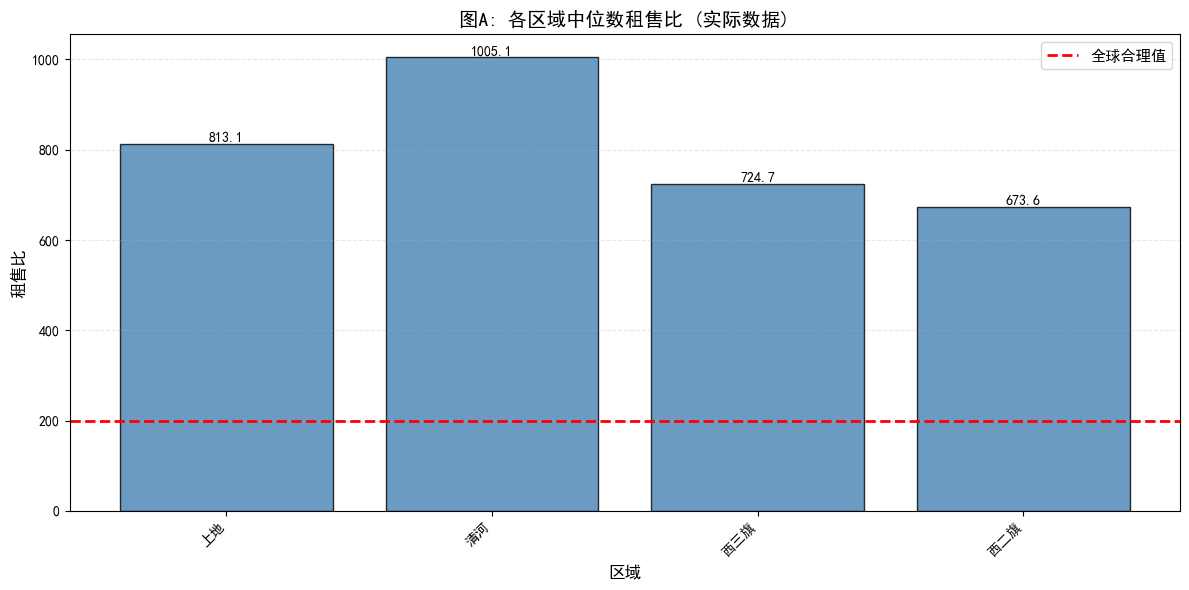


保存处理后的数据...
已保存


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns


# 设置中文显示
plt.rcParams['font.sans-serif'] = ['SimHei', 'Arial Unicode MS', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

# ============================================================
# 1. 读取合并后的数据
# ============================================================
print("读取数据")
df_esf = pd.read_parquet('HW3_My_Data_My_Model/all_esf.parquet')
df_rent = pd.read_parquet('HW3_My_Data_My_Model/all_rent.parquet')

print(f"二手房数据: {len(df_esf)} 条")
print(f"租房数据: {len(df_rent)} 条")

# ============================================================
# 2. 数据描述统计
# ============================================================
print("\n" + "=" * 60)
print("二手房数据描述统计:")
print(df_esf.describe())

print("\n" + "=" * 60)
print("租房数据描述统计:")
print(df_rent.describe())

# ============================================================
# 3. 异常值检测和处理
# ============================================================
print("异常值检测")

# 3.1 检查缺失值
print("\n【二手房缺失值】")
print(df_esf.isnull().sum())

print("\n【租房缺失值】")
print(df_rent.isnull().sum())

# 3.2 删除缺失值
df_esf_clean = df_esf.dropna().copy()
df_rent_clean = df_rent.dropna().copy()

print(f"\n清洗后二手房数据: {len(df_esf_clean)} 条 (删除 {len(df_esf) - len(df_esf_clean)} 条)")
print(f"清洗后租房数据: {len(df_rent_clean)} 条 (删除 {len(df_rent) - len(df_rent_clean)} 条)")

# 3.3 过滤明显不合理的数据（负值）
# 保留面积 > 0 且价格/租金 > 0 的数据
df_esf_clean = df_esf_clean[(df_esf_clean['area'] > 0) & (df_esf_clean['total_price'] > 0)]
df_rent_clean = df_rent_clean[(df_rent_clean['area'] > 0) & (df_rent_clean['rent'] > 0)]

print(f"\n最终二手房数据: {len(df_esf_clean)} 条")
print(f"最终租房数据: {len(df_rent_clean)} 条")

# ============================================================
# 4. 计算每个区域的房价单价和租金单价
# ============================================================
print("\n" + "=" * 60)
print("计算每平米单价")

# 4.1 计算二手房单价（转换单位）
df_esf_clean['price_per_sqm'] = (df_esf_clean['total_price'] * 10000) / df_esf_clean['area']

# 4.2 计算租房单价
df_rent_clean['rent_per_sqm'] = df_rent_clean['rent'] / df_rent_clean['area']

# 4.3 过滤租金单价异常值（这里根据实际情况，保留了单价在50元-500元每平米之间的样本）
print(f"   过滤前租房数据: {len(df_rent_clean)} 条")
df_rent_clean = df_rent_clean[(df_rent_clean['rent_per_sqm'] >= 50) & (df_rent_clean['rent_per_sqm'] <= 500)]
print(f"   过滤后租房数据: {len(df_rent_clean)} 条 (保留租金单价 50-500 元每平米之间的样本)")
print(f"   删除数据: {3822 - len(df_rent_clean)} 条")

print("\n二手房单价 (元/㎡):")
print(df_esf_clean.groupby('location')['price_per_sqm'].describe())

print("\n租金单价 (元/月/㎡):")
print(df_rent_clean.groupby('location')['rent_per_sqm'].describe())

# ============================================================
# 5. 计算每个区域的中位数租售比
# ============================================================
print("\n" + "=" * 60)

# 5.1 按区域分组计算中位数
esf_median = df_esf_clean.groupby('location').agg({
    'price_per_sqm': 'median',
    'area': 'count'
}).rename(columns={'price_per_sqm': 'median_price_per_sqm', 'area': 'esf_count'})

rent_median = df_rent_clean.groupby('location').agg({
    'rent_per_sqm': 'median',
    'area': 'count'
}).rename(columns={'rent_per_sqm': 'median_rent_per_sqm', 'area': 'rent_count'})

# 5.2 合并数据
location_stats = esf_median.join(rent_median, how='outer')

# 5.3 计算租售比
location_stats['rent_to_price_ratio'] = location_stats['median_price_per_sqm'] / location_stats['median_rent_per_sqm']

print("\n各区域统计数据:")
print(location_stats)

# ============================================================
# 6. 绘制图A：各区域中位数租售比柱状图
# ============================================================
print("\n" + "=" * 60)

plt.figure(figsize=(12, 6))

# 提取区域名称（去掉前缀）
locations = location_stats.index.tolist()
location_labels = [loc.split('-')[-1] if '-' in loc else loc for loc in locations]
ratios = location_stats['rent_to_price_ratio'].values

# 绘制柱状图
bars = plt.bar(range(len(location_labels)), ratios, color='steelblue', alpha=0.8, edgecolor='black')

# 添加全球合理值参考线
plt.axhline(y=200, color='red', linestyle='--', linewidth=2, label='全球合理值')

# 在每个柱子上标注数值
for i, (bar, ratio) in enumerate(zip(bars, ratios)):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{ratio:.1f}',
             ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.xlabel('区域', fontsize=12, fontweight='bold')
plt.ylabel('租售比', fontsize=12, fontweight='bold')
plt.title('图A: 各区域中位数租售比 (实际数据)', fontsize=14, fontweight='bold')
plt.xticks(range(len(location_labels)), location_labels, rotation=45, ha='right')
plt.legend(fontsize=11)
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()

# 保存图片
plt.savefig('HW3_My_Data_My_Model/Figure_A_Rent_to_Price_Ratio.png', dpi=300, bbox_inches='tight')
print("图片已保存: HW3_My_Data_My_Model/Figure_A_Rent_to_Price_Ratio.png")
plt.show()

# ============================================================
# 7. 保存处理后的数据
# ============================================================
print("\n" + "=" * 60)
print("保存处理后的数据...")

df_esf_clean.to_parquet('HW3_My_Data_My_Model/esf_clean.parquet', index=False)
df_rent_clean.to_parquet('HW3_My_Data_My_Model/rent_clean.parquet', index=False)
location_stats.to_csv('HW3_My_Data_My_Model/location_stats.csv')

print("已保存")

### 数据建模

#### 基础线性模型

读取清洗后的数据
二手房数据: 4297 条
租房数据: 3783 条

准备模型1数据
   特征数量: 5
   样本数量: 4297
   特征列: ['area', 'location_北京-海淀-上地', 'location_北京-海淀-清河', 'location_北京-海淀-西三旗', 'location_北京-海淀-西二旗']

   R² Score: 0.3961
   RMSE: 21669.71 元/㎡
   MAE: 16600.22 元/㎡

模型系数:
      截距: 68973.52
      面积系数: 76.45
      位置系数: [ 11442.62885733  19931.37948236 -19006.5864014  -12367.4219383 ]

   特征数量: 5
   样本数量: 3783
   特征列: ['area', 'location_北京-海淀-上地', 'location_北京-海淀-清河', 'location_北京-海淀-西三旗', 'location_北京-海淀-西二旗']

   R² Score: 0.0895
   RMSE: 35.21 元/月/㎡
   MAE: 24.21 元/月/㎡

   模型系数:
      截距: 114.79
      面积系数: -0.12
      位置系数: [  3.55654278   5.47607398 -14.10387272   5.07125596]

使用模型预测值计算租售比...

各区域预测租售比:
           predicted_price_per_sqm  predicted_rent_per_sqm  \
location                                                     
北京-海淀-上地              88945.508383              108.302499   
北京-海淀-清河              98613.860083              111.896125   
北京-海淀-西三旗             56848.062459               91.598709   
北

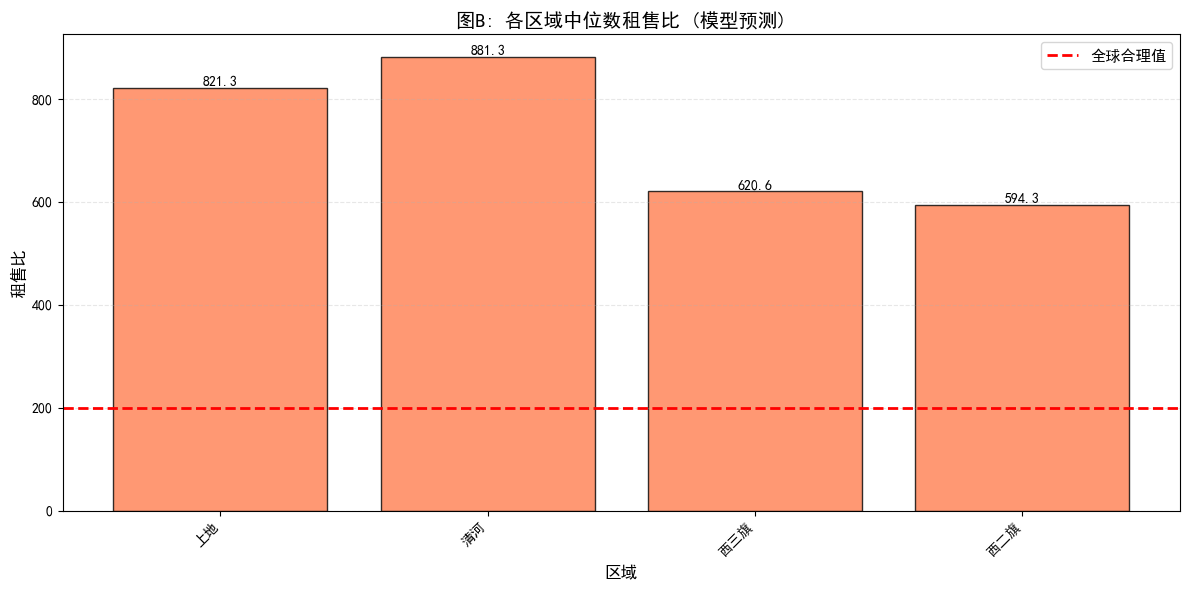


图A vs 图B 对比图
对比图已保存: HW3_My_Data_My_Model/Figure_AB_Comparison.png


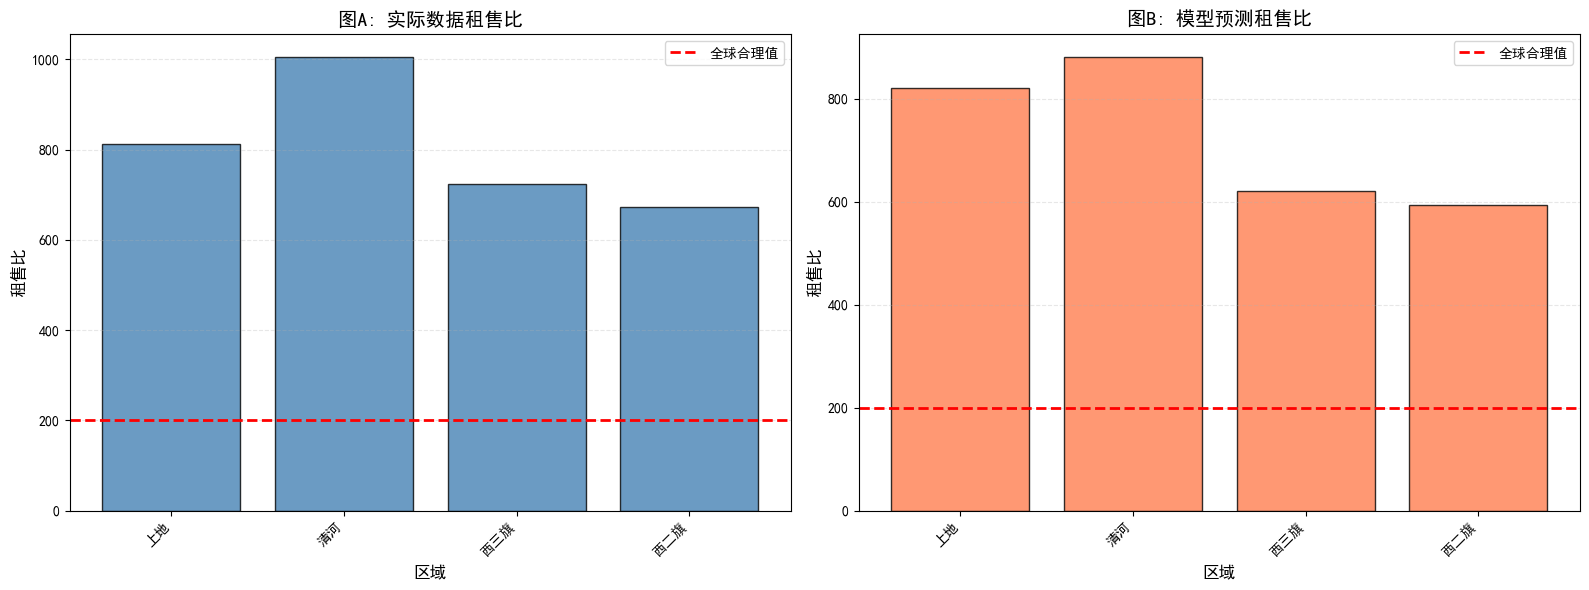


保存模型预测结果...
已保存: predicted_stats.csv
已保存: comparison_actual_vs_predicted.csv


In [6]:
# 导入所需的包

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import LabelEncoder

# 设置中文显示
plt.rcParams['font.sans-serif'] = ['SimHei', 'Arial Unicode MS', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

# ============================================================
# 1. 读取清洗后的数据
# ============================================================
print("=" * 60)
print("读取清洗后的数据")
df_esf = pd.read_parquet('HW3_My_Data_My_Model/esf_clean.parquet')
df_rent = pd.read_parquet('HW3_My_Data_My_Model/rent_clean.parquet')

print(f"二手房数据: {len(df_esf)} 条")
print(f"租房数据: {len(df_rent)} 条")

# ============================================================
# 2. 准备建模数据（二手房）
# ============================================================
print("\n" + "=" * 60)
print("准备模型1数据")

# 2.1 提取特征和目标变量
X_esf = df_esf[['area', 'location']].copy()
y_esf = df_esf['price_per_sqm'].copy()

# 2.2 对location进行one-hot编码
X_esf_encoded = pd.get_dummies(X_esf, columns=['location'], drop_first=False)

print(f"   特征数量: {X_esf_encoded.shape[1]}")
print(f"   样本数量: {X_esf_encoded.shape[0]}")
print(f"   特征列: {list(X_esf_encoded.columns)}")

# ============================================================
# 3. 训练模型1
# ============================================================
print("\n" + "=" * 60)

model1 = LinearRegression()
model1.fit(X_esf_encoded, y_esf)

# 预测
y_esf_pred = model1.predict(X_esf_encoded)

# 评估模型
r2_esf = r2_score(y_esf, y_esf_pred)
rmse_esf = np.sqrt(mean_squared_error(y_esf, y_esf_pred))
mae_esf = mean_absolute_error(y_esf, y_esf_pred)

print(f"   R² Score: {r2_esf:.4f}")
print(f"   RMSE: {rmse_esf:.2f} 元/㎡")
print(f"   MAE: {mae_esf:.2f} 元/㎡")

# 查看系数
print(f"\n模型系数:")
print(f"      截距: {model1.intercept_:.2f}")
print(f"      面积系数: {model1.coef_[0]:.2f}")
if len(model1.coef_) > 1:
    print(f"      位置系数: {model1.coef_[1:]}")

# ============================================================
# 4. 准备建模数据（租房）
# ============================================================
print("\n" + "=" * 60)

# 4.1 提取特征和目标变量
X_rent = df_rent[['area', 'location']].copy()
y_rent = df_rent['rent_per_sqm'].copy()

# 4.2 对location进行one-hot编码
X_rent_encoded = pd.get_dummies(X_rent, columns=['location'], drop_first=False)

print(f"   特征数量: {X_rent_encoded.shape[1]}")
print(f"   样本数量: {X_rent_encoded.shape[0]}")
print(f"   特征列: {list(X_rent_encoded.columns)}")

# ============================================================
# 5. 训练模型2
# ============================================================
print("\n" + "=" * 60)

model2 = LinearRegression()
model2.fit(X_rent_encoded, y_rent)

# 预测
y_rent_pred = model2.predict(X_rent_encoded)

# 评估模型
r2_rent = r2_score(y_rent, y_rent_pred)
rmse_rent = np.sqrt(mean_squared_error(y_rent, y_rent_pred))
mae_rent = mean_absolute_error(y_rent, y_rent_pred)

print(f"   R² Score: {r2_rent:.4f}")
print(f"   RMSE: {rmse_rent:.2f} 元/月/㎡")
print(f"   MAE: {mae_rent:.2f} 元/月/㎡")

# 查看系数
print(f"\n   模型系数:")
print(f"      截距: {model2.intercept_:.2f}")
print(f"      面积系数: {model2.coef_[0]:.2f}")
if len(model2.coef_) > 1:
    print(f"      位置系数: {model2.coef_[1:]}")

# ============================================================
# 6. 使用模型预测值计算租售比
# ============================================================
print("\n" + "=" * 60)
print("使用模型预测值计算租售比...")

# 6.1 将预测值添加到原数据框
df_esf['predicted_price_per_sqm'] = y_esf_pred
df_rent['predicted_rent_per_sqm'] = y_rent_pred

# 6.2 按区域计算预测值的中位数
esf_pred_median = df_esf.groupby('location')['predicted_price_per_sqm'].median()
rent_pred_median = df_rent.groupby('location')['predicted_rent_per_sqm'].median()

# 6.3 创建预测统计表
pred_stats = pd.DataFrame({
    'predicted_price_per_sqm': esf_pred_median,
    'predicted_rent_per_sqm': rent_pred_median
})

# 6.4 计算基于预测值的租售比
pred_stats['predicted_rent_to_price_ratio'] = pred_stats['predicted_price_per_sqm'] / pred_stats['predicted_rent_per_sqm']

# 6.5 添加样本数量信息
pred_stats['esf_count'] = df_esf.groupby('location').size()
pred_stats['rent_count'] = df_rent.groupby('location').size()

print("\n各区域预测租售比:")
print(pred_stats)

# ============================================================
# 7. 绘制图B：模型预测的租售比柱状图
# ============================================================
print("\n" + "=" * 60)
print("绘制图B：模型预测的租售比柱状图")

plt.figure(figsize=(12, 6))

# 提取区域名称
locations = pred_stats.index.tolist()
location_labels = [loc.split('-')[-1] if '-' in loc else loc for loc in locations]
ratios_pred = pred_stats['predicted_rent_to_price_ratio'].values

# 绘制柱状图
bars = plt.bar(range(len(location_labels)), ratios_pred, color='coral', alpha=0.8, edgecolor='black')

# 添加全球合理值参考线
plt.axhline(y=200, color='red', linestyle='--', linewidth=2, label='全球合理值')

# 在每个柱子上标注数值
for i, (bar, ratio) in enumerate(zip(bars, ratios_pred)):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{ratio:.1f}',
             ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.xlabel('区域', fontsize=12, fontweight='bold')
plt.ylabel('租售比', fontsize=12, fontweight='bold')
plt.title('图B: 各区域中位数租售比 (模型预测)', fontsize=14, fontweight='bold')
plt.xticks(range(len(location_labels)), location_labels, rotation=45, ha='right')
plt.legend(fontsize=11)
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()

# 保存图片
plt.savefig('HW3_My_Data_My_Model/Figure_B_Predicted_Rent_to_Price_Ratio.png', dpi=300, bbox_inches='tight')
print("图片已保存: HW3_My_Data_My_Model/Figure_B_Predicted_Rent_to_Price_Ratio.png")
plt.show()

# ============================================================
# 8. 对比图A和图B
# ============================================================
print("\n" + "=" * 60)
print("图A vs 图B 对比图")

# 读取之前的实际数据统计
location_stats = pd.read_csv('HW3_My_Data_My_Model/location_stats.csv', index_col=0)

# 合并实际值和预测值
comparison = pd.DataFrame({
    'actual': location_stats['rent_to_price_ratio'],
    'predicted': pred_stats['predicted_rent_to_price_ratio']
})

# 绘制对比图
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 图A - 实际租售比
locations = comparison.index.tolist()
location_labels = [loc.split('-')[-1] if '-' in loc else loc for loc in locations]

axes[0].bar(range(len(location_labels)), comparison['actual'].values, 
            color='steelblue', alpha=0.8, edgecolor='black')
axes[0].axhline(y=200, color='red', linestyle='--', linewidth=2, label='全球合理值')
axes[0].set_xlabel('区域', fontsize=12, fontweight='bold')
axes[0].set_ylabel('租售比', fontsize=12, fontweight='bold')
axes[0].set_title('图A: 实际数据租售比', fontsize=14, fontweight='bold')
axes[0].set_xticks(range(len(location_labels)))
axes[0].set_xticklabels(location_labels, rotation=45, ha='right')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3, linestyle='--')

# 图B - 预测租售比
axes[1].bar(range(len(location_labels)), comparison['predicted'].values, 
            color='coral', alpha=0.8, edgecolor='black')
axes[1].axhline(y=200, color='red', linestyle='--', linewidth=2, label='全球合理值')
axes[1].set_xlabel('区域', fontsize=12, fontweight='bold')
axes[1].set_ylabel('租售比', fontsize=12, fontweight='bold')
axes[1].set_title('图B: 模型预测租售比', fontsize=14, fontweight='bold')
axes[1].set_xticks(range(len(location_labels)))
axes[1].set_xticklabels(location_labels, rotation=45, ha='right')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig('HW3_My_Data_My_Model/Figure_AB_Comparison.png', dpi=300, bbox_inches='tight')
print("对比图已保存: HW3_My_Data_My_Model/Figure_AB_Comparison.png")
plt.show()

# ============================================================
# 9. 保存模型预测结果
# ============================================================
print("\n" + "=" * 60)
print("保存模型预测结果...")

pred_stats.to_csv('HW3_My_Data_My_Model/predicted_stats.csv')
comparison.to_csv('HW3_My_Data_My_Model/comparison_actual_vs_predicted.csv')

print("已保存: predicted_stats.csv")
print("已保存: comparison_actual_vs_predicted.csv")

经过基础建模，发现二手房预测效果一般，且租房预测效果比较差，因此考虑添加更多特征。

### 添加非线性和交叉项的模型

读取清洗后的数据...
二手房数据: 4297 条
租房数据: 3783 条

模型1plus 特征工程
   添加非线性特征:
      - area_squared (面积的平方)
      - area_sqrt (面积开根号)
      - area_log (log(面积))
      - area_inv (1/面积)
添加交互项: area × location (4 个)
   模型1plus 特征数量: 13
   样本数量: 4297

   R² Score: 0.4804
   RMSE: 20100.58 元/㎡
   MAE: 15593.26 元/㎡

模型2plus 特征工程
   添加非线性特征:
      - area_squared (面积平方)
      - area_sqrt (面积开根号)
      - area_log (log(面积))
      - area_inv (1/面积)
   添加交互项: area × location (4 个)
   模型2plus 特征数量: 13
   样本数量: 3783

   R² Score: 0.5177
   RMSE: 25.62 元/月/㎡
   MAE: 15.73 元/月/㎡

模型性能对比

     模型  R² Score         RMSE          MAE  特征数量
    模型1  0.396083 21669.713862 16600.220844     5
模型1plus  0.480377 20100.581347 15593.262891    13
    模型2  0.089465    35.210196    24.211639     5
模型2plus  0.517737    25.624906    15.725894    13

使用高级模型预测值计算租售比...

各区域高级模型预测租售比:
           predicted_price_per_sqm_plus  predicted_rent_per_sqm_plus  \
location                                                               
北京-海淀-

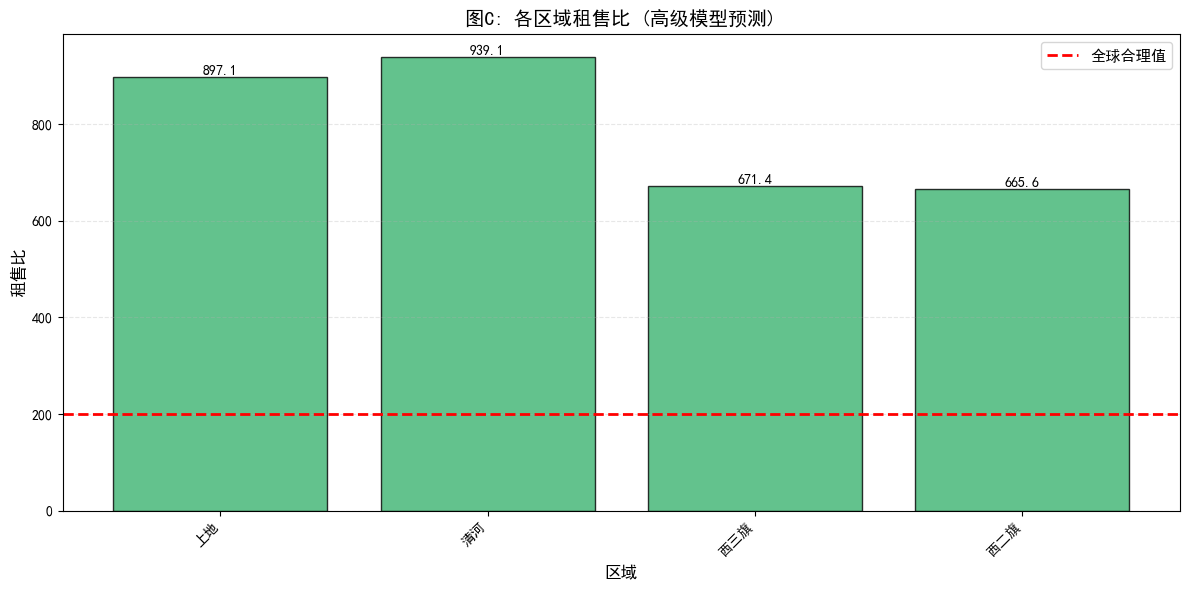


绘制综合对比图
综合对比图已保存: HW3_My_Data_My_Model/Figure_ABC_Complete_Comparison.png


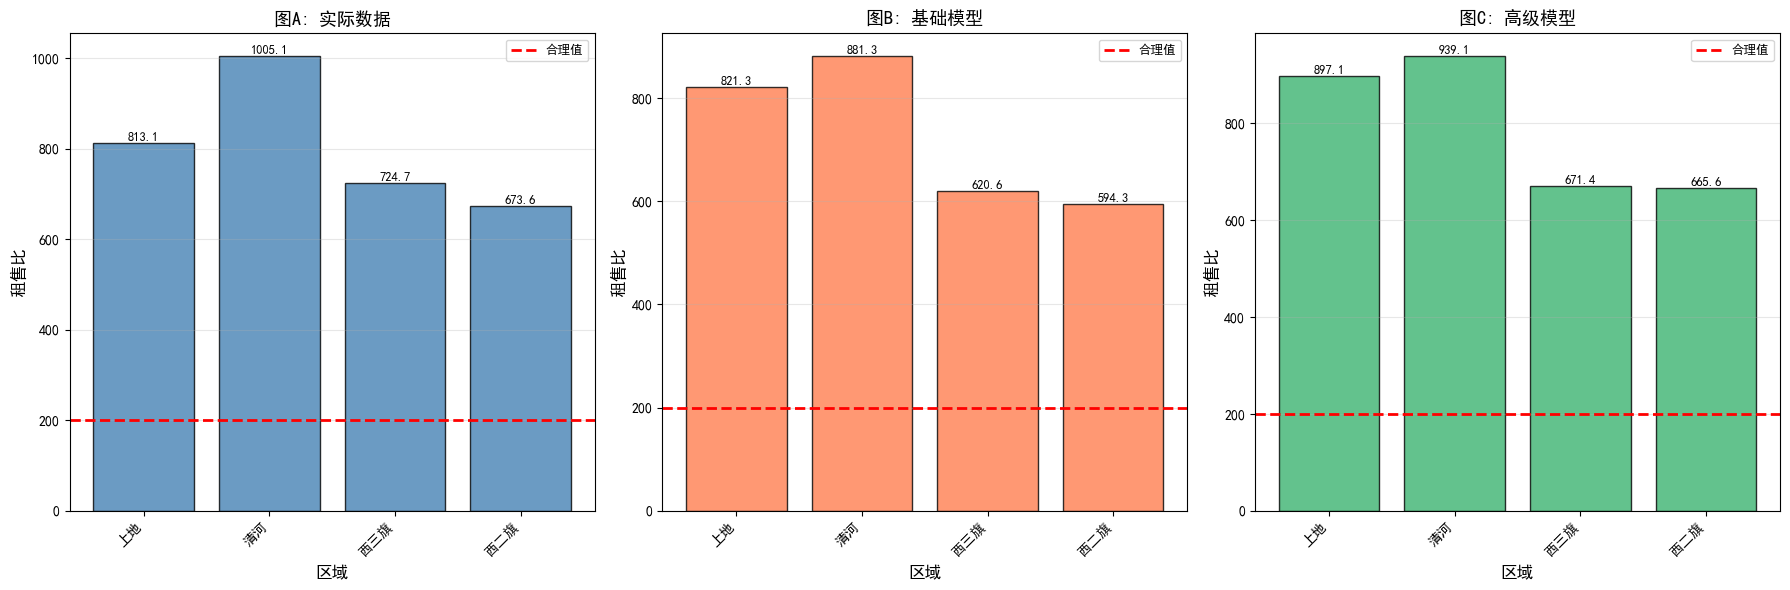


绘制分组柱状图...
分组柱状图已保存: HW3_My_Data_My_Model/Figure_Grouped_Comparison.png


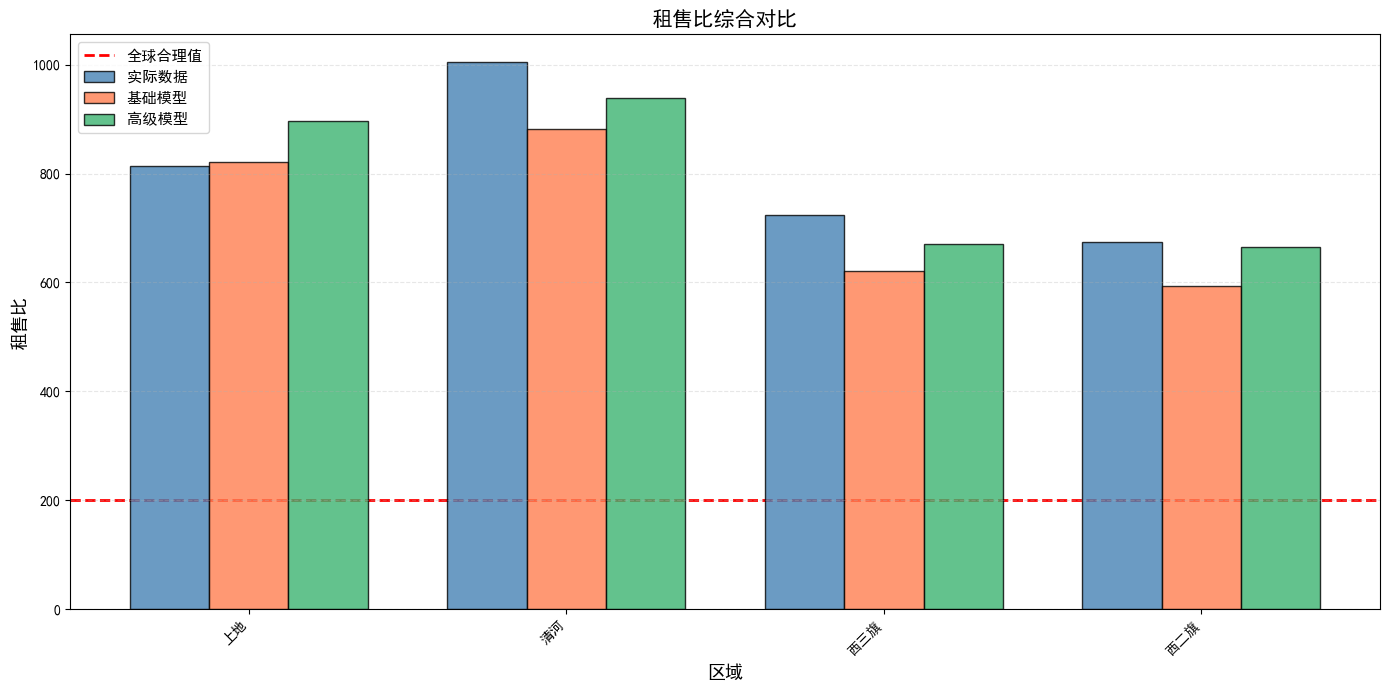


保存分析结果...
已保存: advanced_model_stats.csv


In [8]:
# ============================================================
# 添加非线性和交叉项的模型
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import PolynomialFeatures
import warnings

# 设置中文显示
plt.rcParams['font.sans-serif'] = ['SimHei', 'Arial Unicode MS', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

# ============================================================
# 1. 读取清洗后的数据
# ============================================================
print("=" * 60)
print("读取清洗后的数据...")
df_esf = pd.read_parquet('HW3_My_Data_My_Model/esf_clean.parquet')
df_rent = pd.read_parquet('HW3_My_Data_My_Model/rent_clean.parquet')

print(f"二手房数据: {len(df_esf)} 条")
print(f"租房数据: {len(df_rent)} 条")

# ============================================================
# 2. 特征工程 - 模型1plus: 添加非线性特征和交互项
# ============================================================
print("\n" + "=" * 60)
print("模型1plus 特征工程")

# 2.1 准备基础数据
df_esf_advanced = df_esf.copy()

# 2.2 添加非线性特征
df_esf_advanced['area_squared'] = df_esf_advanced['area'] ** 2  # 面积平方
df_esf_advanced['area_sqrt'] = np.sqrt(df_esf_advanced['area'])  # 面积开方
df_esf_advanced['area_log'] = np.log(df_esf_advanced['area'] + 1)  # 面积对数
df_esf_advanced['area_inv'] = 1 / (df_esf_advanced['area'] + 1)  # 面积倒数

print("   添加非线性特征:")
print("      - area_squared (面积的平方)")
print("      - area_sqrt (面积开根号)")
print("      - area_log (log(面积))")
print("      - area_inv (1/面积)")

# 2.3 对location进行one-hot编码
location_dummies = pd.get_dummies(df_esf_advanced['location'], prefix='loc')
df_esf_advanced = pd.concat([df_esf_advanced, location_dummies], axis=1)

# 2.4 添加交互项 (area × location)
for col in location_dummies.columns:
    df_esf_advanced[f'area_x_{col}'] = df_esf_advanced['area'] * df_esf_advanced[col]

print(f"添加交互项: area × location ({len(location_dummies.columns)} 个)")

# 2.5 准备特征矩阵
feature_cols_esf = ['area', 'area_squared', 'area_sqrt', 'area_log', 'area_inv']
feature_cols_esf += list(location_dummies.columns)
feature_cols_esf += [col for col in df_esf_advanced.columns if col.startswith('area_x_loc_')]

X_esf_advanced = df_esf_advanced[feature_cols_esf]
y_esf = df_esf_advanced['price_per_sqm']

print(f"   模型1plus 特征数量: {X_esf_advanced.shape[1]}")
print(f"   样本数量: {X_esf_advanced.shape[0]}")

# ============================================================
# 3. 训练模型1plus（二手房））
# ============================================================
print("\n" + "=" * 60)

model1_plus = LinearRegression()
model1_plus.fit(X_esf_advanced, y_esf)

# 预测
y_esf_pred_plus = model1_plus.predict(X_esf_advanced)

# 评估模型
r2_esf_plus = r2_score(y_esf, y_esf_pred_plus)
rmse_esf_plus = np.sqrt(mean_squared_error(y_esf, y_esf_pred_plus))
mae_esf_plus = mean_absolute_error(y_esf, y_esf_pred_plus)

print(f"   R² Score: {r2_esf_plus:.4f}")
print(f"   RMSE: {rmse_esf_plus:.2f} 元/㎡")
print(f"   MAE: {mae_esf_plus:.2f} 元/㎡")

# ============================================================
# 4. 特征工程 - 模型2plus: 添加非线性特征和交互项
# ============================================================
print("\n" + "=" * 60)
print("模型2plus 特征工程")

# 4.1 准备基础数据
df_rent_advanced = df_rent.copy()

# 4.2 添加非线性特征
df_rent_advanced['area_squared'] = df_rent_advanced['area'] ** 2
df_rent_advanced['area_sqrt'] = np.sqrt(df_rent_advanced['area'])
df_rent_advanced['area_log'] = np.log(df_rent_advanced['area'] + 1)
df_rent_advanced['area_inv'] = 1 / (df_rent_advanced['area'] + 1)

print("   添加非线性特征:")
print("      - area_squared (面积平方)")
print("      - area_sqrt (面积开根号)")
print("      - area_log (log(面积))")
print("      - area_inv (1/面积)")

# 4.3 对location进行one-hot编码
location_dummies_rent = pd.get_dummies(df_rent_advanced['location'], prefix='loc')
df_rent_advanced = pd.concat([df_rent_advanced, location_dummies_rent], axis=1)

# 4.4 添加交互项 (area × location)
for col in location_dummies_rent.columns:
    df_rent_advanced[f'area_x_{col}'] = df_rent_advanced['area'] * df_rent_advanced[col]

print(f"   添加交互项: area × location ({len(location_dummies_rent.columns)} 个)")

# 4.5 准备特征矩阵
feature_cols_rent = ['area', 'area_squared', 'area_sqrt', 'area_log', 'area_inv']
feature_cols_rent += list(location_dummies_rent.columns)
feature_cols_rent += [col for col in df_rent_advanced.columns if col.startswith('area_x_loc_')]

X_rent_advanced = df_rent_advanced[feature_cols_rent]
y_rent = df_rent_advanced['rent_per_sqm']

print(f"   模型2plus 特征数量: {X_rent_advanced.shape[1]}")
print(f"   样本数量: {X_rent_advanced.shape[0]}")

# ============================================================
# 5. 训练模型2plus: rent/m² (高级版)
# ============================================================
print("\n" + "=" * 60)

model2_plus = LinearRegression()
model2_plus.fit(X_rent_advanced, y_rent)

# 预测
y_rent_pred_plus = model2_plus.predict(X_rent_advanced)

# 评估模型
r2_rent_plus = r2_score(y_rent, y_rent_pred_plus)
rmse_rent_plus = np.sqrt(mean_squared_error(y_rent, y_rent_pred_plus))
mae_rent_plus = mean_absolute_error(y_rent, y_rent_pred_plus)

print(f"   R² Score: {r2_rent_plus:.4f}")
print(f"   RMSE: {rmse_rent_plus:.2f} 元/月/㎡")
print(f"   MAE: {mae_rent_plus:.2f} 元/月/㎡")

# ============================================================
# 6. 模型对比分析
# ============================================================
print("\n" + "=" * 60)
print("模型性能对比")

# 读取基础模型结果
# 重新训练基础模型,获取R方
from sklearn.linear_model import LinearRegression

# 基础模型1
X_esf_basic = pd.get_dummies(df_esf[['area', 'location']], columns=['location'])
y_esf_basic = df_esf['price_per_sqm']
model1_basic = LinearRegression()
model1_basic.fit(X_esf_basic, y_esf_basic)
r2_esf_basic = r2_score(y_esf_basic, model1_basic.predict(X_esf_basic))

# 基础模型2
X_rent_basic = pd.get_dummies(df_rent[['area', 'location']], columns=['location'])
y_rent_basic = df_rent['rent_per_sqm']
model2_basic = LinearRegression()
model2_basic.fit(X_rent_basic, y_rent_basic)
r2_rent_basic = r2_score(y_rent_basic, model2_basic.predict(X_rent_basic))

# 创建对比表
comparison_df = pd.DataFrame({
    '模型': ['模型1', '模型1plus', '模型2', '模型2plus'],
    'R² Score': [r2_esf_basic, r2_esf_plus, r2_rent_basic, r2_rent_plus],
    'RMSE': [
        np.sqrt(mean_squared_error(y_esf_basic, model1_basic.predict(X_esf_basic))),
        rmse_esf_plus,
        np.sqrt(mean_squared_error(y_rent_basic, model2_basic.predict(X_rent_basic))),
        rmse_rent_plus
    ],
    'MAE': [
        mean_absolute_error(y_esf_basic, model1_basic.predict(X_esf_basic)),
        mae_esf_plus,
        mean_absolute_error(y_rent_basic, model2_basic.predict(X_rent_basic)),
        mae_rent_plus
    ],
    '特征数量': [X_esf_basic.shape[1], X_esf_advanced.shape[1], 
                X_rent_basic.shape[1], X_rent_advanced.shape[1]]
})

print("\n" + comparison_df.to_string(index=False))


# ============================================================
# 7. 使用模型1+和模型2+计算租售比
# ============================================================
print("\n" + "=" * 60)
print("使用高级模型预测值计算租售比...")

# 7.1 将预测值添加到原数据框
df_esf_advanced['predicted_price_per_sqm_plus'] = y_esf_pred_plus
df_rent_advanced['predicted_rent_per_sqm_plus'] = y_rent_pred_plus

# 7.2 按区域计算预测值的中位数
esf_pred_median_plus = df_esf_advanced.groupby('location')['predicted_price_per_sqm_plus'].median()
rent_pred_median_plus = df_rent_advanced.groupby('location')['predicted_rent_per_sqm_plus'].median()

# 7.3 创建预测统计表
pred_stats_plus = pd.DataFrame({
    'predicted_price_per_sqm_plus': esf_pred_median_plus,
    'predicted_rent_per_sqm_plus': rent_pred_median_plus
})

# 7.4 计算基于高级模型预测值的租售比
pred_stats_plus['predicted_rent_to_price_ratio_plus'] = (
    pred_stats_plus['predicted_price_per_sqm_plus'] / pred_stats_plus['predicted_rent_per_sqm_plus']
)

# 7.5 添加样本数量信息
pred_stats_plus['esf_count'] = df_esf_advanced.groupby('location').size()
pred_stats_plus['rent_count'] = df_rent_advanced.groupby('location').size()

print("\n各区域高级模型预测租售比:")
print(pred_stats_plus)

# ============================================================
# 8. 绘制图C：基于高级模型的租售比柱状图
# ============================================================
print("\n" + "=" * 60)
print("绘制图C：基于高级模型预测的租售比柱状图...")

plt.figure(figsize=(12, 6))

# 提取区域名称
locations = pred_stats_plus.index.tolist()
location_labels = [loc.split('-')[-1] if '-' in loc else loc for loc in locations]
ratios_plus = pred_stats_plus['predicted_rent_to_price_ratio_plus'].values

# 绘制柱状图
bars = plt.bar(range(len(location_labels)), ratios_plus, color='mediumseagreen', alpha=0.8, edgecolor='black')

# 添加全球合理值参考线
plt.axhline(y=200, color='red', linestyle='--', linewidth=2, label='全球合理值')

# 在每个柱子上标注数值
for i, (bar, ratio) in enumerate(zip(bars, ratios_plus)):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{ratio:.1f}',
             ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.xlabel('区域', fontsize=12, fontweight='bold')
plt.ylabel('租售比', fontsize=12, fontweight='bold')
plt.title('图C: 各区域租售比 (高级模型预测)', fontsize=14, fontweight='bold')
plt.xticks(range(len(location_labels)), location_labels, rotation=45, ha='right')
plt.legend(fontsize=11)
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()

# 保存图片
plt.savefig('HW3_My_Data_My_Model/Figure_C_Advanced_Rent_to_Price_Ratio.png', dpi=300, bbox_inches='tight')
print("图片已保存: HW3_My_Data_My_Model/Figure_C_Advanced_Rent_to_Price_Ratio.png")
plt.show()

# ============================================================
# 9. 综合对比：图A vs 图B vs 图C
# ============================================================
print("\n" + "=" * 60)
print("绘制综合对比图")

# 读取实际数据统计和基础模型预测
location_stats = pd.read_csv('HW3_My_Data_My_Model/location_stats.csv', index_col=0)
pred_stats_basic = pd.read_csv('HW3_My_Data_My_Model/predicted_stats.csv', index_col=0)

# 合并所有方法的结果
all_comparison = pd.DataFrame({
    '实际数据': location_stats['rent_to_price_ratio'],
    '基础模型': pred_stats_basic['predicted_rent_to_price_ratio'],
    '高级模型': pred_stats_plus['predicted_rent_to_price_ratio_plus']
})

# 绘制三种方法对比图
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

locations = all_comparison.index.tolist()
location_labels = [loc.split('-')[-1] if '-' in loc else loc for loc in locations]

# 图A - 实际租售比
axes[0].bar(range(len(location_labels)), all_comparison['实际数据'].values, 
            color='steelblue', alpha=0.8, edgecolor='black')
axes[0].axhline(y=200, color='red', linestyle='--', linewidth=2, label='合理值')
for i, val in enumerate(all_comparison['实际数据'].values):
    axes[0].text(i, val, f'{val:.1f}', ha='center', va='bottom', fontsize=9, fontweight='bold')
axes[0].set_xlabel('区域', fontsize=12, fontweight='bold')
axes[0].set_ylabel('租售比', fontsize=12, fontweight='bold')
axes[0].set_title('图A: 实际数据', fontsize=13, fontweight='bold')
axes[0].set_xticks(range(len(location_labels)))
axes[0].set_xticklabels(location_labels, rotation=45, ha='right')
axes[0].legend(fontsize=9)
axes[0].grid(axis='y', alpha=0.3)

# 图B - 基础模型
axes[1].bar(range(len(location_labels)), all_comparison['基础模型'].values, 
            color='coral', alpha=0.8, edgecolor='black')
axes[1].axhline(y=200, color='red', linestyle='--', linewidth=2, label='合理值')
for i, val in enumerate(all_comparison['基础模型'].values):
    axes[1].text(i, val, f'{val:.1f}', ha='center', va='bottom', fontsize=9, fontweight='bold')
axes[1].set_xlabel('区域', fontsize=12, fontweight='bold')
axes[1].set_ylabel('租售比', fontsize=12, fontweight='bold')
axes[1].set_title('图B: 基础模型', fontsize=13, fontweight='bold')
axes[1].set_xticks(range(len(location_labels)))
axes[1].set_xticklabels(location_labels, rotation=45, ha='right')
axes[1].legend(fontsize=9)
axes[1].grid(axis='y', alpha=0.3)

# 图C - 高级模型
axes[2].bar(range(len(location_labels)), all_comparison['高级模型'].values, 
            color='mediumseagreen', alpha=0.8, edgecolor='black')
axes[2].axhline(y=200, color='red', linestyle='--', linewidth=2, label='合理值')
for i, val in enumerate(all_comparison['高级模型'].values):
    axes[2].text(i, val, f'{val:.1f}', ha='center', va='bottom', fontsize=9, fontweight='bold')
axes[2].set_xlabel('区域', fontsize=12, fontweight='bold')
axes[2].set_ylabel('租售比', fontsize=12, fontweight='bold')
axes[2].set_title('图C: 高级模型', fontsize=13, fontweight='bold')
axes[2].set_xticks(range(len(location_labels)))
axes[2].set_xticklabels(location_labels, rotation=45, ha='right')
axes[2].legend(fontsize=9)
axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('HW3_My_Data_My_Model/Figure_ABC_Complete_Comparison.png', dpi=300, bbox_inches='tight')
print("综合对比图已保存: HW3_My_Data_My_Model/Figure_ABC_Complete_Comparison.png")
plt.show()


# ============================================================
# 10. 绘制分组柱状图
# ============================================================
print("\n" + "=" * 60)
print("绘制分组柱状图...")

fig, ax = plt.subplots(figsize=(14, 7))

x = np.arange(len(location_labels))
width = 0.25

bars1 = ax.bar(x - width, all_comparison['实际数据'].values, width, 
               label='实际数据', color='steelblue', alpha=0.8, edgecolor='black')
bars2 = ax.bar(x, all_comparison['基础模型'].values, width, 
               label='基础模型', color='coral', alpha=0.8, edgecolor='black')
bars3 = ax.bar(x + width, all_comparison['高级模型'].values, width, 
               label='高级模型', color='mediumseagreen', alpha=0.8, edgecolor='black')

# 添加参考线
ax.axhline(y=200, color='red', linestyle='--', linewidth=2, label='全球合理值', zorder=0)

ax.set_xlabel('区域', fontsize=13, fontweight='bold')
ax.set_ylabel('租售比', fontsize=13, fontweight='bold')
ax.set_title('租售比综合对比', fontsize=15, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(location_labels, rotation=45, ha='right')
ax.legend(fontsize=11, loc='upper left')
ax.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig('HW3_My_Data_My_Model/Figure_Grouped_Comparison.png', dpi=300, bbox_inches='tight')
print("分组柱状图已保存: HW3_My_Data_My_Model/Figure_Grouped_Comparison.png")
plt.show()



# ============================================================
# 11. 保存所有结果
# ============================================================
print("\n" + "=" * 60)
print("保存分析结果...")

pred_stats_plus.to_csv('HW3_My_Data_My_Model/advanced_model_stats.csv')
all_comparison.to_csv('HW3_My_Data_My_Model/complete_comparison.csv')
comparison_df.to_csv('HW3_My_Data_My_Model/model_performance_comparison.csv', index=False)

print("已保存: advanced_model_stats.csv")